In [274]:
import matplotlib.pyplot as plt
import numpy as np
import math
import time

## Fetch  historical stock prices

Use www.alphavantage.co

In [315]:
def get_stock_prices(symbol):
    import requests
    import datetime

    # Set API Key
    API_KEY = "CPH5HXXLYYVHFQ2Z"

    symbol = "AAPL"

    # Calculate date range for the last 365 days
    end_date = datetime.date.today()
    start_date = end_date - datetime.timedelta(days=365)

    # API endpoint for Alpha Vantage
    url = f"https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol={symbol}&apikey={API_KEY}&outputsize=full"

    # Make API request
    response = requests.get(url)
    data = response.json()

    # Extract stock prices for the last 365 days
    prices = []
    for date in data['Time Series (Daily)']:
        date_obj = datetime.datetime.strptime(date, "%Y-%m-%d").date()
        if start_date <= date_obj <= end_date:
            prices.append({
                "date": date,
                "open": data["Time Series (Daily)"][date]["1. open"],
                "high": data["Time Series (Daily)"][date]["2. high"],
                "low": data["Time Series (Daily)"][date]["3. low"],
                "close": data["Time Series (Daily)"][date]["4. close"],
                "volume": data["Time Series (Daily)"][date]["5. volume"],
            })

    return prices       


#### Fetch IBM Historical Prices

In [394]:
real_prices =   get_stock_prices("IBM") 

# Convert String Results to float array
opens = np.squeeze([float(prices[i]['open']) for i in range(0, len(prices))])

## Calculate Drift 
To calculate the continuously compounded returns (drift), use the np.log() function to calculate the natural logarithm of the ratio of each stock price to the previous stock price. Slice the stock_prices array to exclude the first element, since there is no previous price to calculate returns from.

Then find the mean of the continuously compounded returns using the np.mean() function.

To calculate the stock price drift,  add the mean of the continuously compounded returns to half the variance of the returns, which is multiplied by the time increment. In this case, we assume a time increment of 1 day.

In [398]:
# Define the function to calculate drift
def calculate_drift(stock_prices): 
    
    log_returns = np.log(stock_prices / np.roll(stock_prices, 2))
    
    # alternative calc
    #log_returns = np.log(stock_prices[1:] / stock_prices[:-1])
    '''from chatGPT
       So, the key difference between np.roll(x, 2) and x[:-1] is the 
       way they shift the elements of the array. np.roll(x, 2) wraps 
       the elements around the array, while x[:-1] removes the last 
       element. Additionally, np.roll(x, 2) returns an array of the 
       same size as the input x, while x[:-1] returns an array that is
       one element shorter than x.
    '''
    
    mean_return = log_returns.mean()
    
    drift = mean_return + (0.5 * log_returns.var())
    
    return drift

# Calc drift function
real_drift = calculate_drift(opens)
print('Drift =', real_drift)

Drift = 0.00043351238605708614



# Calculating a Stocks Volatility
One popular method to calculate the volatility of a stock is the "rolling window" approach, where you calculate the standard deviation of the returns over a specific time period (e.g., 50 days) and then "roll" the time period forward by one day and repeat the calculation.

Calculate the daily returns of the stock using the pct_change() functi, then calculate the rolling standard deviation of returns using a specified day window size

In [399]:
import pandas as pd
#Convert Opens to a dataframe

def calc_volatility(prices, window=50):
    actualdf = pd.DataFrame({'prices':opens})

    #Calcuate Daily Returns
    actualdf['Returns'] = actualdf['prices'].pct_change()

    window_size = window
    actualdf['Volatility'] = actualdf['Returns'].rolling(window_size).std() * np.sqrt(window_size)
    
    return actualdf['Volatility'].mean(), actualdf

volatility, actualdf = calc_volatility(opens, 50)

print('Volatility = ' ,volatility)

Volatility =  0.14952768447750892


The below is a graph highlighting the calculated historical returns against the calculated volatility

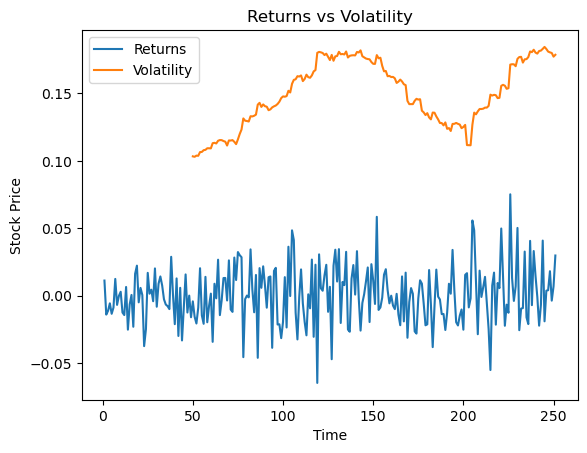

In [400]:
plt.plot(actualdf['Returns'], label='Returns')
plt.plot(actualdf['Volatility'], label='Volatility')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.title('Returns vs Volatility')
plt.legend()

plt.show()

## Calculate a Simple Monte Carlo Simulation
Requires the following Parameters

    open_price - this represents the starting point of the simulation
    sigma - the volatility calculated in the previous step
    r - the risk free rate
    T - the time increment window 1
    N - number of days for the simulation (252 corresponds to the number of trading days in a year )
    M - the number of simulations (i.e. 1000)
    
Use a nested loop to generate random normal variables to simulate the stock price changes. For each simulation (i),iterate through the time steps (j) and calculate the new stock price based on the previous stock price (prices[i,j-1]), the risk-free rate, the volatility (sigma), and a random normal variable (np.random.normal()).

In [431]:
def monte_carlo(open_price, sigma, r, T, N, M):

    # Define the initial stock price, volatility, and time horizon
    price0 = open_price


    # Define the number of time steps and the time increment
    dt = T/N

    # Create a M x N+1 matrix to store the results
    prices = np.zeros((M, N+1))
    prices[:,0] = price0

    # Generate random normal variables to simulate the stock price changes
    for i in range(M):
        for j in range(1, N+1):
            prices[i,j] = prices[i,j-1] * np.exp((r - 0.5*sigma**2)*dt + sigma*np.sqrt(dt)*np.random.normal())
            
    
    mean_price = np.mean(prices, axis=0)
    
    return prices, mean_price


# Calc monte_carlo sim
T  = 1
N  = 252
dt = T/N
r  = 0
M  = 1000

mc_sim_prices, mc_sim_mean = monte_carlo(opens[0], volatility, r, T, N, M)

####   Plot Simualtion Results

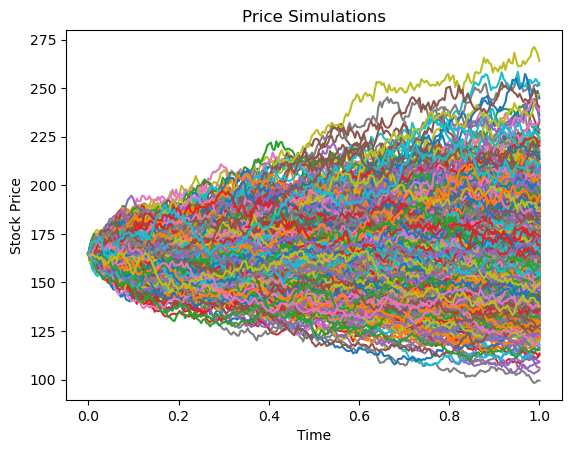

In [432]:
 # Plot the simulated stock prices
plt.plot(np.arange(0, T+dt, dt), mc_sim_prices.T)
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.title('Price Simulations')
plt.show()


## Plot comparison of simulated vs actual prices

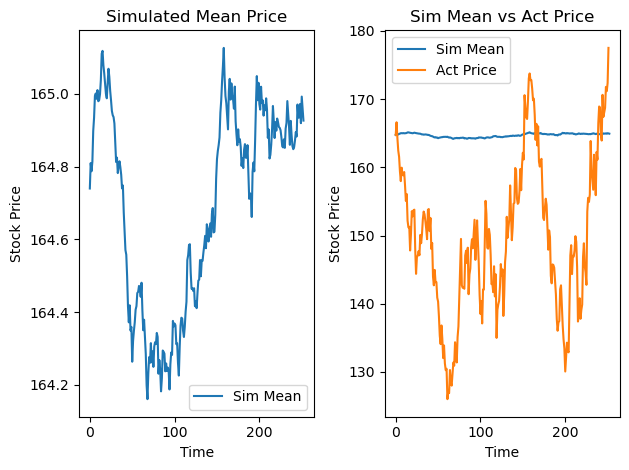

In [518]:
# create a figure with two subplots arranged horizontally
fig, (ax1, ax2) = plt.subplots(1, 2)


#Plot the simulated mean price
ax1.plot(mc_sim_mean, label='Sim Mean')
ax1.set_xlabel('Time')
ax1.set_ylabel('Stock Price')
ax1.set_title('Simulated Mean Price')
ax1.legend()

#Plot the simulated mean price compared to the Actual
ax2.plot(mc_sim_mean, label='Sim Mean')
ax2.plot(opens, label='Act Price')
ax2.set_xlabel('Time')
ax2.set_ylabel('Stock Price')
ax2.set_title('Sim Mean vs Act Price')
ax2.legend()

# adjust the layout of the subplots to prevent overlapping
fig.tight_layout()

plt.show()


## Plot the Actual vs Simulated Distribution

Actual (mean, var, stddev):  149.5794761904762 122.86127386848077 11.08428048492462
Simulated (mean, var, stddev):  164.20645610250205 0.05702704526868134 0.23880336109167588


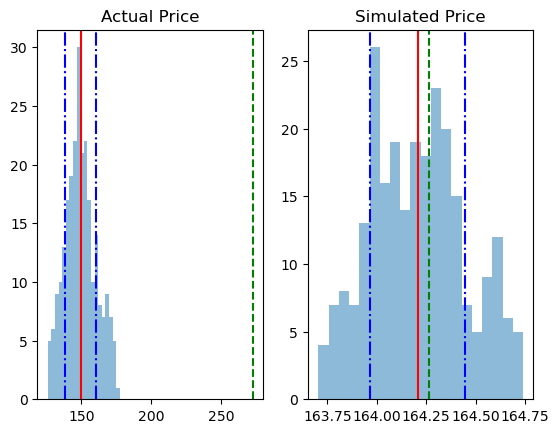

In [420]:
real_mean = np.mean(opens)
real_variance = np.var(opens)
real_std_deviation = np.std(opens)

print('Actual (mean, var, stddev): ',real_mean, real_variance, real_std_deviation)


sim_mean = np.mean(mc_sim_mean)
sim_variance = np.var(mc_sim_mean)
sim_std_deviation = np.std(mc_sim_mean)

print('Simulated (mean, var, stddev): ',sim_mean, sim_variance, sim_std_deviation)

# create a figure with two subplots arranged horizontally
fig, (hist1, hist2) = plt.subplots(1, 2)

# Plot a histogram of the actual data
hist1.hist(opens, bins=20, alpha=0.5)

# Add vertical lines for the mean, variance, and standard deviation
hist1.axvline(x=real_mean, color='r', label='Mean')
hist1.axvline(x=real_mean+real_variance, color='g', linestyle='--', label='Variance')
hist1.axvline(x=real_mean-real_std_deviation, color='b', linestyle='-.', label='Standard Deviation')
hist1.axvline(x=real_mean+real_std_deviation, color='b', linestyle='-.', label='Standard Deviation')

# Add legend and show the plot
hist1.set_title('Actual Price')
#plt.legend()


# Plot a histogram of the simulated data
hist2.hist(mc_sim_mean, bins=20, alpha=0.5)

# Add vertical lines for the mean, variance, and standard deviation
hist2.axvline(x=sim_mean, color='r', label='Mean')
hist2.axvline(x=sim_mean+sim_variance, color='g', linestyle='--', label='Variance')
hist2.axvline(x=sim_mean-sim_std_deviation, color='b', linestyle='-.', label='Standard Deviation')
hist2.axvline(x=sim_mean+sim_std_deviation, color='b', linestyle='-.', label='Standard Deviation')

# Add legend and show the plot
hist2.set_title('Simulated Price')
#hist2.legend()
plt.show()



## Geometric Brownian Motion calculator
A guide to the notion of securities pricing with code

reference: https://towardsdatascience.com/monte-carlo-pricing-in-python-eafc29e3b6c9

Requires the following Parameters:

    open_price - this represents the starting point of the simulation
    sigma - the volatility calculated above
    drift - calculated above
    T - the time increment window 1
    N - number of days for the simulation (252 corresponds to the number of trading days in a year )
    
This implementation of Geometric Brownian Motion ignore the risk free and introduces the drift variable

In [480]:
class GeometricBrownianMotion:

    def simulate_paths(self):
        while(self.T - self.dt > 0):
            dWt = np.random.normal(0, math.sqrt(self.dt))  # Brownian motion
            dYt = self.drift*self.dt + self.volatility*dWt  # Change in price
            self.current_price += dYt  # Add the change to the current price
            self.prices.append(self.current_price)  # Append new price to series
            self.T -= self.dt  # Accound for the step in time
            #print(self.T)

    def __init__(self, initial_price, drift, volatility, N, T):
        self.current_price = initial_price
        self.initial_price = initial_price
        self.drift = drift
        self.volatility = volatility
        self.dt = T/N
        self.T = T
        self.prices = []
        self.simulate_paths()
        #print(self.dt)

### Execute the Monte Carlo Simualtion using Brownian Motion

In [523]:
# Model Parameters
M = 1000
N = 252
T = 1
bm_prices = np.zeros((M, N+1))
bm_prices[:,0] = opens[0]
price_paths = []

# Generate a set of sample paths
for i in range(0, M):
    #price_paths.append(GeometricBrownianMotion(opens[0], drift, volatility, N, T).prices)
    bm_prices[i, 1:] = GeometricBrownianMotion(opens[0], .05, volatility, N, T).prices
    
    
# Calculate Mean price across all paths
bm_sim_mean = np.mean(bm_prices, axis=0)

In [524]:
print(len(bm_sim_mean))

253


## Plot Comaprison of Brownian Motion Simulation to Monte Carlo Simulation

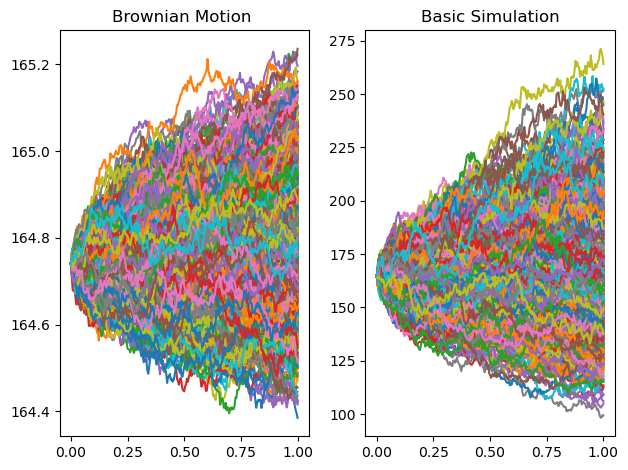

In [525]:
# create a figure with two subplots arranged horizontally
fig, (ax1, ax2) = plt.subplots(1, 2)


#Plot the simulated mean price
ax1.plot(np.arange(0, T+dt, dt), bm_prices.T)
#ax1.set_xlabel('Time')
#ax1.set_ylabel('Stock Price')
ax1.set_title('Brownian Motion ')
#ax1.legend()

#Plot the simulated mean price compared to the Actual
ax2.plot(np.arange(0, T+dt, dt), mc_sim_prices.T)
#ax2.set_xlabel('Time')
#ax2.set_ylabel('Stock Price')
ax2.set_title('Basic Simulation')


# adjust the layout of the subplots to prevent overlapping
fig.tight_layout()

plt.show()


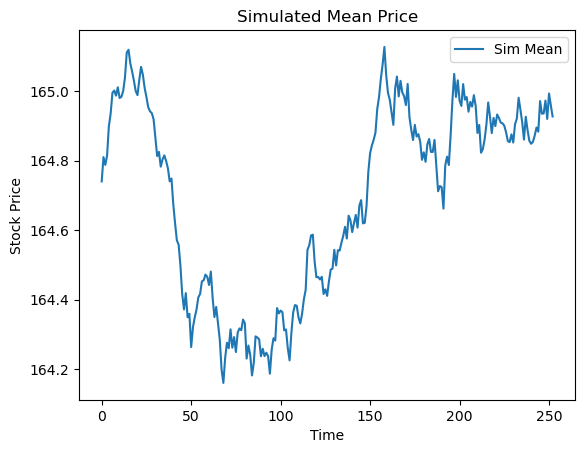

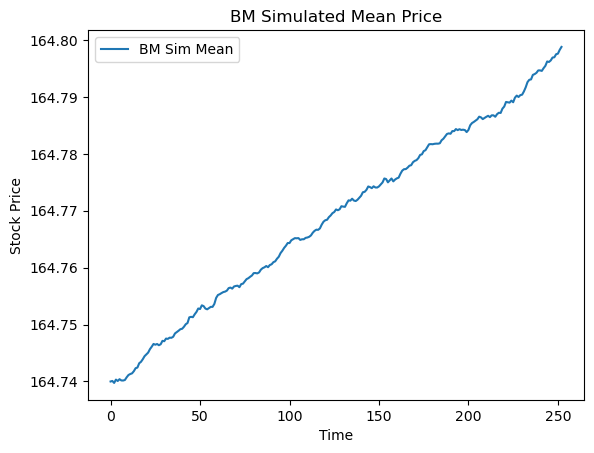

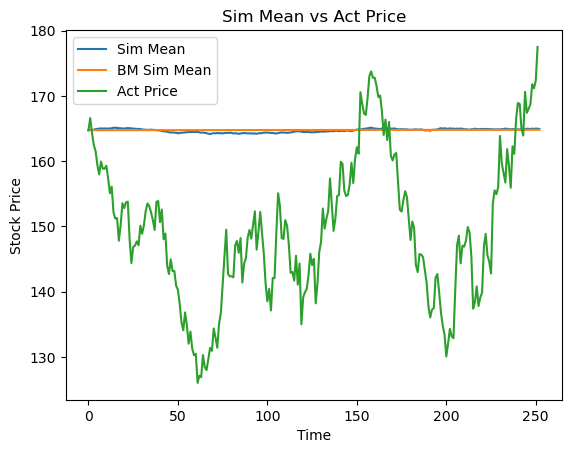

In [528]:

#Plot the simulated mean price
plt.plot(mc_sim_mean, label='Sim Mean')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.title('Simulated Mean Price')
plt.legend()
plt.show()

#Plot the simulated mean price
plt.plot(bm_sim_mean, label='BM Sim Mean')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.title('BM Simulated Mean Price')
plt.legend()

plt.show()

#Plot the simulated mean price compared to the Actual
plt.plot(mc_sim_mean, label='Sim Mean')
plt.plot(bm_sim_mean, label='BM Sim Mean')
plt.plot(opens, label='Act Price')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.title('Sim Mean vs Act Price')
plt.legend()

# adjust the layout of the subplots to prevent overlapping
#fig.tight_layout()

plt.show()


# BELOW STILL NEEDS WORK

## Black Scholes Pricing

Reference: https://towardsdatascience.com/monte-carlo-pricing-in-python-eafc29e3b6c9

In [310]:
import math
from scipy.stats import norm


class EuropeanCall:

    def call_price(
        self, asset_price, asset_volatility, strike_price,
        time_to_expiration, risk_free_rate
            ):
        b = math.exp(-risk_free_rate*time_to_expiration)
        x1 = math.log(asset_price/(b*strike_price)) + .5*(asset_volatility*asset_volatility)*time_to_expiration
        x1 = x1/(asset_volatility*(time_to_expiration**.5))
        z1 = norm.cdf(x1)
        z1 = z1*asset_price
        x2 = math.log(asset_price/(b*strike_price)) - .5*(asset_volatility*asset_volatility)*time_to_expiration
        x2 = x2/(asset_volatility*(time_to_expiration**.5))
        z2 = norm.cdf(x2)
        z2 = b*strike_price*z2
        return z1 - z2

    def __init__(
        self, asset_price, asset_volatility, strike_price,
        time_to_expiration, risk_free_rate
            ):
        self.asset_price = asset_price
        self.asset_volatility = asset_volatility
        self.strike_price = strike_price
        self.time_to_expiration = time_to_expiration
        self.risk_free_rate = risk_free_rate
        self.price = self.call_price(asset_price, asset_volatility, strike_price, time_to_expiration, risk_free_rate)
        

class EuropeanPut:

    def put_price(
        self, asset_price, asset_volatility, strike_price,
        time_to_expiration, risk_free_rate
            ):
        b = math.exp(-risk_free_rate*time_to_expiration)
        x1 = math.log((b*strike_price)/asset_price) + .5*(asset_volatility*asset_volatility)*time_to_expiration
        x1 = x1/(asset_volatility*(time_to_expiration**.5))
        z1 = norm.cdf(x1)
        z1 = b*strike_price*z1
        x2 = math.log((b*strike_price)/asset_price) - .5*(asset_volatility*asset_volatility)*time_to_expiration
        x2 = x2/(asset_volatility*(time_to_expiration**.5))
        z2 = norm.cdf(x2)
        z2 = asset_price*z2
        return z1 - z2

    def __init__(
        self, asset_price, asset_volatility, strike_price,
        time_to_expiration, risk_free_rate
            ):
        self.asset_price = asset_price
        self.asset_volatility = asset_volatility
        self.strike_price = strike_price
        self.time_to_expiration = time_to_expiration
        self.risk_free_rate = risk_free_rate
        self.price = self.put_price(asset_price, asset_volatility, strike_price, time_to_expiration, risk_free_rate)
        
ec = EuropeanCall(100, .3, 100, 1, .01)
print(ec.price)

12.368267463784072


# Monte Carlo Pricing

Reference: https://towardsdatascience.com/monte-carlo-pricing-in-python-eafc29e3b6c9

In [311]:
class European_Call_Payoff:

    def __init__(self, strike):
        self.strike = strike

    def get_payoff(self, stock_price):
        if stock_price > self.strike:
            return stock_price - self.strike
        else:
            return 0

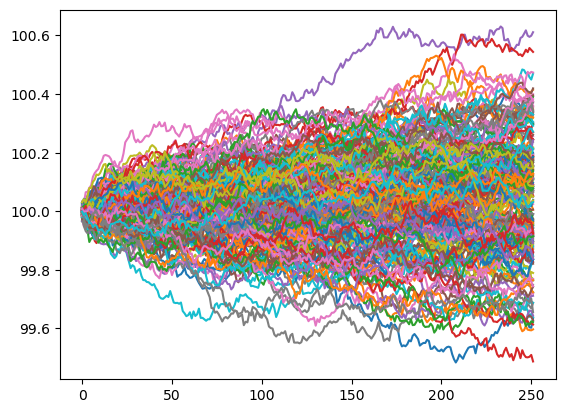

11.335331250034098


In [312]:
# Generate a set of sample paths
for i in range(0, paths):
    price_paths.append(GeometricBrownianMotion(initial_price, drift, volatility, dt, T).prices)

call_payoffs = []
ec = European_Call_Payoff(100)
risk_free_rate = .01
for price_path in price_paths:
    call_payoffs.append(ec.get_payoff(price_path[-1])/(1 + risk_free_rate))  # We get the last stock price in the series generated by GBM to determine the payoff and discount it by one year

# Plot the set of generated sample paths
for price_path in price_paths:
    plt.plot(price_path)
plt.show()

print(np.average(call_payoffs)*100)  # Options are in blocks of 100